In [ ]:
!pip install ISLP

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
     QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
df = load_data('Weekly')
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1089 non-null   int64   
 1   Lag1       1089 non-null   float64 
 2   Lag2       1089 non-null   float64 
 3   Lag3       1089 non-null   float64 
 4   Lag4       1089 non-null   float64 
 5   Lag5       1089 non-null   float64 
 6   Volume     1089 non-null   float64 
 7   Today      1089 non-null   float64 
 8   Direction  1089 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 69.4 KB


# Applied: A

In [ ]:
df.Year.value_counts()

,count
Year,
2007,53
1996,53
2000,52
2001,52
2009,52
2008,52
2006,52
2005,52
2004,52


In [ ]:
df.Direction.value_counts(normalize = True)

,proportion
Direction,
Up,0.555556
Down,0.444444


<Axes: title={'center': 'Volume trades weekly'}>

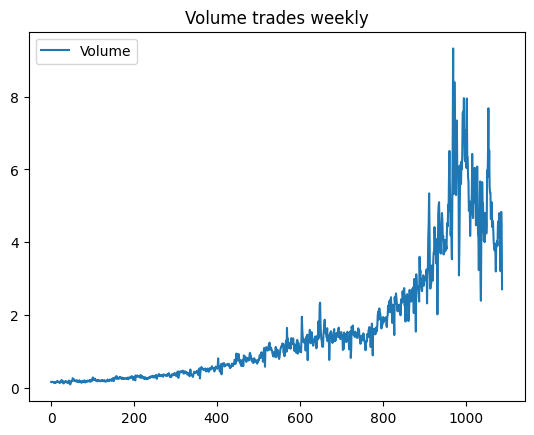

In [ ]:
df.plot(y = 'Volume', title = 'Volume trades weekly')

<Axes: >

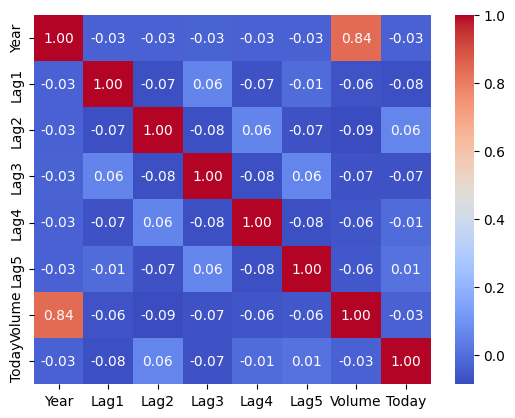

In [ ]:
df1 = df.drop('Direction', axis = 1)
sns.heatmap(df1.corr(), annot = True, fmt = '2.2f', cmap = 'coolwarm')

1. It seens to be a positive trend on the volume of the stocks.
2. We can see theres a strong positive relationship between Year and Volume due to the positive trend.
3. We got low correlated features and theres seens to be not a colineality problem with the features except for the Year & Volume.


In [ ]:
y = (df['Direction'] == 'Up').astype(int)
X = df.drop('Direction', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2025)
model = sm.GLM(y_train, X_train, families = sm.families.Binomial()).fit()
summarize(model)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['families']
  warnings.warn(msg, ValueWarning)


,coef,std err,z,P>|z|
Year,0.0003,0.000009,30.160,0.000
Lag1,-0.0008,0.006000,-0.138,0.890
Lag2,0.0070,0.006000,1.279,0.201
Lag3,0.0058,0.005000,1.056,0.291
Lag4,-0.0056,0.006000,-1.001,0.317
Lag5,-0.0062,0.006000,-1.085,0.278
Volume,0.0044,0.008000,0.569,0.569
Today,0.1470,0.005000,27.926,0.000


Theres significance in the variables of Today & Year with really low p-values and low std errors which means theres stability in the coefficients.

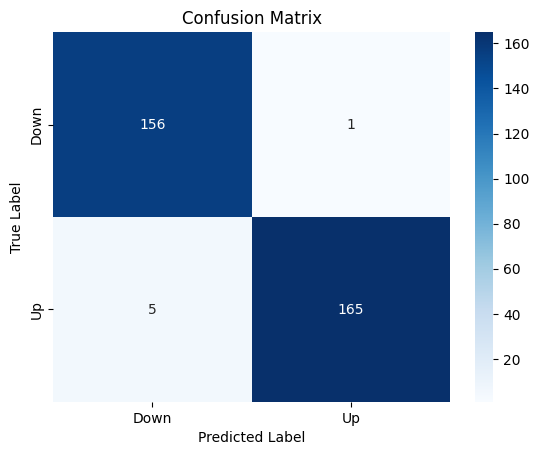

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.55).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)


def cm(conf_matrix):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

cm(conf_matrix)





In [ ]:
def cr(report):
    print("Clasification Report:")
    report_df = pd.DataFrame(report).transpose()
    print(report_df)
report = classification_report(y_test, y_pred, target_names=['Down', 'Up'], output_dict=True)
cr(report)

Clasification Report:
              precision    recall  f1-score     support
Down           0.968944  0.993631  0.981132  157.000000
Up             0.993976  0.970588  0.982143  170.000000
accuracy       0.981651  0.981651  0.981651    0.981651
macro avg      0.981460  0.982109  0.981637  327.000000
weighted avg   0.981958  0.981651  0.981658  327.000000


C) The model is almost perfect, we get only 6 errors, 1 for False Negative and 5 False Positives


In [ ]:
#Part D:
'''Nowfitthe logistic regression model using a training data period
 from 1990 to 2008, with Lag2 as the only predictor. Compute the
 confusion matrix and the overall fraction of correct predictions
 for the held out data (that is, the data from 2009 and 2010)'''

train = df['Year'] <= 2008
X = df[['Lag2']]
y = (df['Direction'] == 'Up').astype(int)

X_train, y_train = X[train], y[train]
X_test, y_test = X[~train], y[~train]

X_train.isna().sum()
model = sm.GLM(y_train, X_train, families = sm.families.Binomial()).fit()

summarize(model)








/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['families']
  warnings.warn(msg, ValueWarning)


,coef,std err,z,P>|z|
Lag2,0.0279,0.01,2.682,0.007


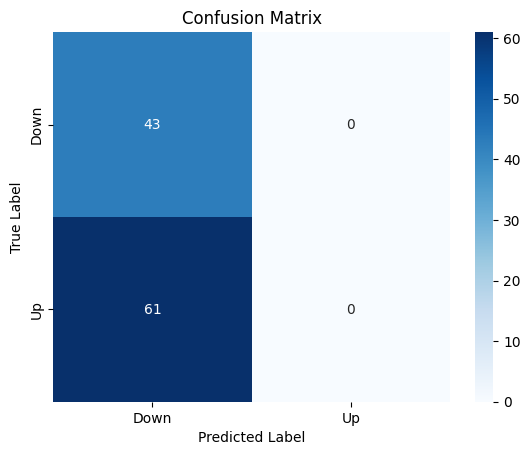

In [ ]:
model_prob = model.predict(X_test)
model_preds = (model_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, model_preds)
cm(conf_matrix)


In [ ]:
report = classification_report(y_test, model_preds, target_names=['Down', 'Up'], output_dict=True)
cr(report)

Clasification Report:
              precision    recall  f1-score     support
Down           0.413462  1.000000  0.585034   43.000000
Up             0.000000  0.000000  0.000000   61.000000
accuracy       0.413462  0.413462  0.413462    0.413462
macro avg      0.206731  0.500000  0.292517  104.000000
weighted avg   0.170950  0.413462  0.241889  104.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


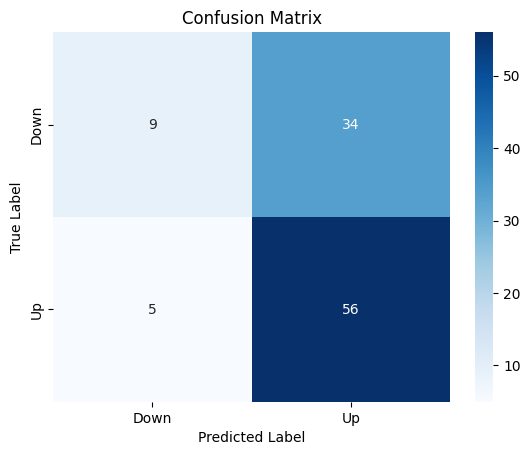

Clasification Report:
              precision    recall  f1-score  support
Down           0.642857  0.209302  0.315789   43.000
Up             0.622222  0.918033  0.741722   61.000
accuracy       0.625000  0.625000  0.625000    0.625
macro avg      0.632540  0.563668  0.528756  104.000
weighted avg   0.630754  0.625000  0.565615  104.000


In [ ]:
lda = LDA(store_covariance  = True)
model = lda.fit(X_train, y_train)
model_pred = lda.predict(X_test)
conf_m = confusion_matrix(y_test, model_pred)
cm(conf_m)
report = classification_report(y_test, model_pred, target_names=['Down', 'Up'], output_dict=True )
cr(report)

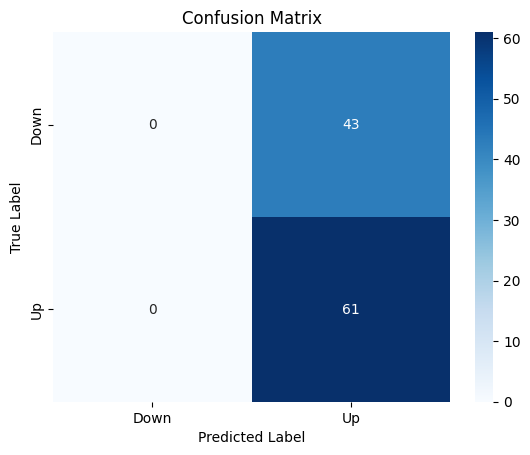

Clasification Report:
              precision    recall  f1-score     support
Down           0.000000  0.000000  0.000000   43.000000
Up             0.586538  1.000000  0.739394   61.000000
accuracy       0.586538  0.586538  0.586538    0.586538
macro avg      0.293269  0.500000  0.369697  104.000000
weighted avg   0.344027  0.586538  0.433683  104.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
qda = QDA()
model = qda.fit(X_train, y_train)
model_pred = qda.predict(X_test)
conf_m = confusion_matrix(y_test, model_pred)
cm(conf_m)
report = classification_report(y_test, model_pred, target_names=['Down', 'Up'], output_dict=True )
cr(report)

for k: 1


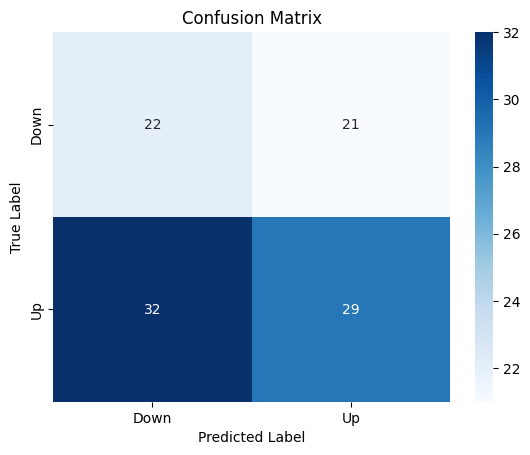



Clasification Report:
              precision    recall  f1-score     support
Down           0.407407  0.511628  0.453608   43.000000
Up             0.580000  0.475410  0.522523   61.000000
accuracy       0.490385  0.490385  0.490385    0.490385
macro avg      0.493704  0.493519  0.488065  104.000000
weighted avg   0.508640  0.490385  0.494029  104.000000
for k: 2


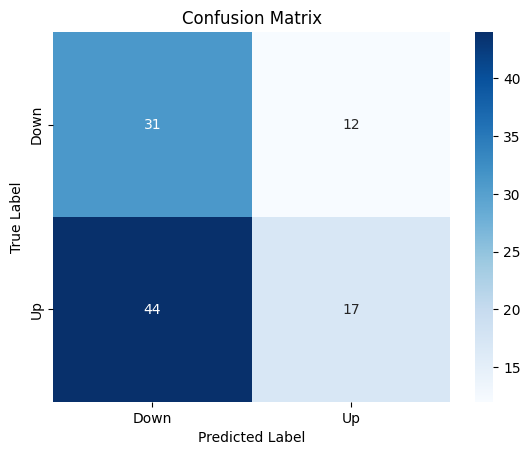



Clasification Report:
              precision    recall  f1-score     support
Down           0.413333  0.720930  0.525424   43.000000
Up             0.586207  0.278689  0.377778   61.000000
accuracy       0.461538  0.461538  0.461538    0.461538
macro avg      0.499770  0.499809  0.451601  104.000000
weighted avg   0.514730  0.461538  0.438824  104.000000
for k: 3


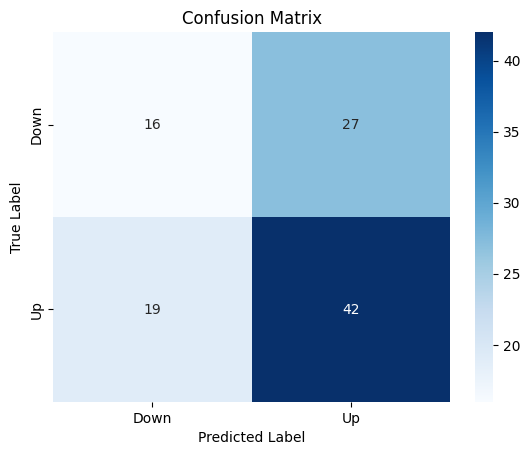



Clasification Report:
              precision    recall  f1-score     support
Down           0.457143  0.372093  0.410256   43.000000
Up             0.608696  0.688525  0.646154   61.000000
accuracy       0.557692  0.557692  0.557692    0.557692
macro avg      0.532919  0.530309  0.528205  104.000000
weighted avg   0.546034  0.557692  0.548619  104.000000


In [ ]:
for i in range(1,4):
    print(f'for k: {i}')
    knn = KNeighborsClassifier(n_neighbors= i)
    model = knn.fit(X_train, y_train)
    model_pred = knn.predict(X_test)
    cmx = confusion_matrix(y_test, model_pred)
    cm(cmx)
    print('\n')
    report = classification_report(y_test, model_pred, target_names=['Down', 'Up'], output_dict=True )
    cr(report)


KNN gave the best results of the models when k = 4, but they all really bad.

# Interaction + transformations

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Lag2    1089 non-null   float64
dtypes: float64(1)
memory usage: 8.6 KB


In [ ]:
X = df.drop(['Direction', 'Volume'], axis = 1)
y = (df['Direction'] == 'Up').astype(int)


train = df['Year'] <= 2008
X_train, X_test = X[train], X[~train]
y_train, y_test = y[train], y[~train]
model = sm.GLM(y_train, X_train, families = sm.families.Binomial()).fit()
summarize(model)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['families']
  warnings.warn(msg, ValueWarning)


,coef,std err,z,P>|z|
Year,0.0003,0.000006,47.747,0.000
Lag1,-0.0005,0.005000,-0.108,0.914
Lag2,0.0033,0.005000,0.676,0.499
Lag3,0.0066,0.005000,1.346,0.178
Lag4,-0.0045,0.005000,-0.917,0.359
Lag5,-0.0076,0.005000,-1.547,0.122
Today,0.1570,0.005000,32.168,0.000


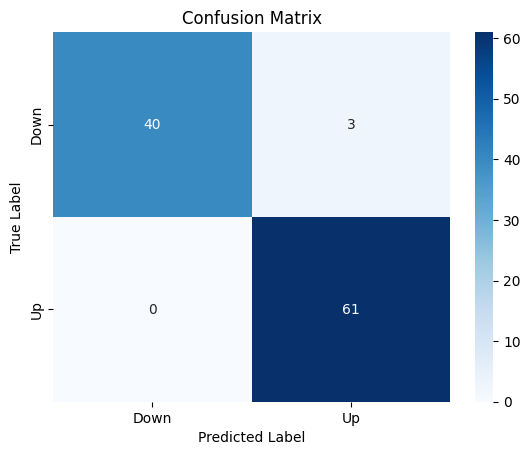

In [ ]:
model_pred_probs = model.predict(X_test)
model_preds = (model_pred_probs >= 0.50).astype(int)
conf_m = confusion_matrix(y_test, model_preds)
cm(conf_m)

With Interactions

In [ ]:
from patsy import dmatrices, dmatrix
import statsmodels.api as sm

predictors = '+'.join(X.columns)
formula = f"{predictors} + {predictors}:({predictors})"


X_train_interaction = dmatrix(formula, data=X_train, return_type='dataframe')
X_test_interaction = dmatrix(formula, data=X_test, return_type='dataframe')

X_train_interaction = sm.add_constant(X_train_interaction)
X_test_interaction = sm.add_constant(X_test_interaction)

model = sm.GLM(y_train, X_train_interaction, family=sm.families.Binomial()).fit()


print(model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  985
Model:                            GLM   Df Residuals:                      971
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 08 Jan 2025   Deviance:                       0.0000
Time:                        21:02:42   Pearson chi2:                     0.00
No. Iterations:                    20   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.769e+15   7.95e+08  -2.22e+06      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(

The problem is that we have such a clear separation in the densities of the class that our coefficients tend to be really high, close to inf and close to 0. Lets plot to see if our hypothesis is true.

<Axes: xlabel='Lag1', ylabel='Density'>

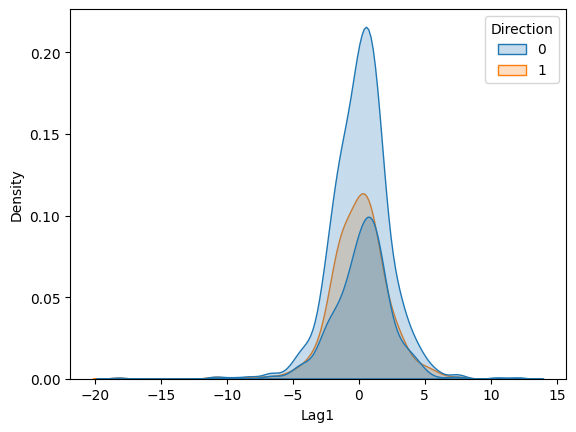

In [ ]:
sns.kdeplot(data = X_train_interaction, x = 'Lag1', fill=True, hue = y_train)
sns.kdeplot(data = X_train_interaction, x = 'Lag1', fill=True)


<Axes: xlabel='Today', ylabel='Density'>

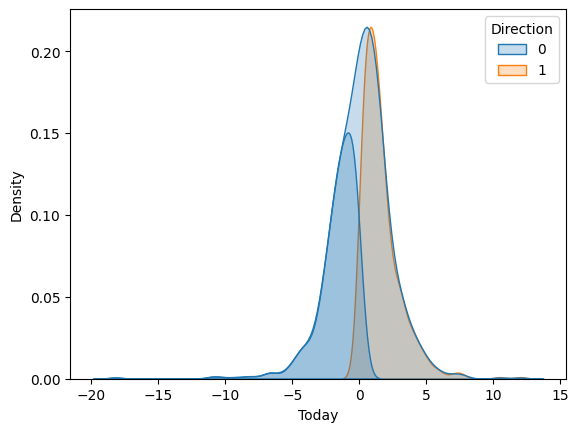

In [ ]:
sns.kdeplot(data = X_train_interaction, x = 'Today', fill=True, hue = y_train)
sns.kdeplot(data = X_train_interaction, x = 'Today', fill=True)

<Axes: xlabel='Year', ylabel='Density'>

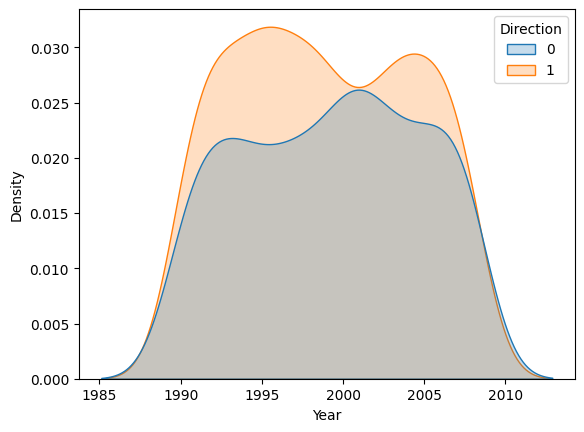

In [ ]:
sns.kdeplot(data = X_train_interaction, x = 'Year', fill=True, hue = y_train)

its seems theres a clear separation on the distributions when:

P(Y = 1|Today > 2)

We can also see that every variable tends to follow a normal distribution, with the exception of year which follows a uniform distribution becouse every year has the same number of observations (weekly frequency).

# Conclusion: LDA will be the best model to fit the data

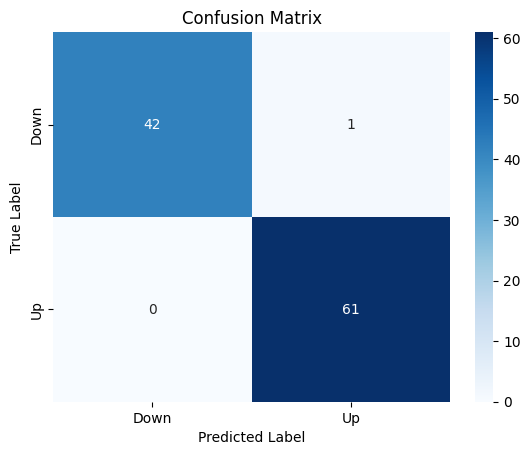

In [ ]:
lda = LDA()
model = lda.fit(X_train, y_train)
model_preds = model.predict(X_test)
conf_m = confusion_matrix(y_test, model_preds)
cm(conf_m)

We almost got a perfect score. The model is able to predict with 99%.

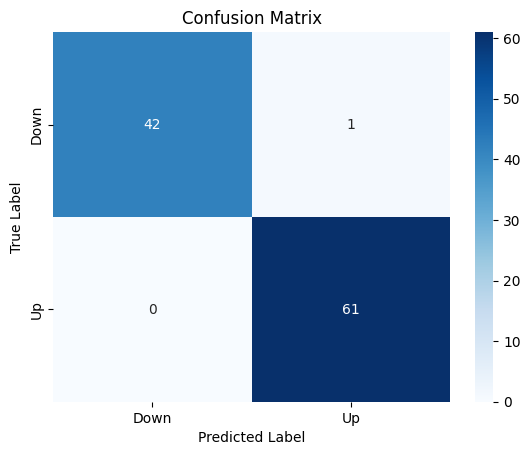

In [ ]:
lda = LDA()
model = lda.fit(X_train_interaction, y_train)
model_preds = model.predict(X_test_interaction)
conf_m = confusion_matrix(y_test, model_preds)
cm(conf_m)



The simplier model gets the same results as the complex one with the interactions, so we would choose the simplier model.